#Imports, installations and setups

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geohash2

In [3]:
!pip install pytorch_lightning > /dev/null
print("Pytorch_lightning: installed")

Pytorch_lightning: installed


In [4]:
!pip install torch_geometric > /dev/null
print("Torch_geometric: installed")

Torch_geometric: installed


In [5]:
import requests
import pandas as pd
import os
import geohash2
import numpy as np

# Dataset preparation:

In [ ]:
# Column names
checkins_columns = [
    'User_ID',
    'Venue_ID',
    'UTC_Time',
    'Timezone_Offset'
]

venue_columns = [
    'Venue_ID',
    'Latitude',
    'Longitude',
    'Venue_Category_Name',
    'Country_Code'
]

path_C = "/content/drive/MyDrive/POI_files/dataset_TIST2015_Checkins.txt"
path_V = "/content/drive/MyDrive/POI_files/dataset_TIST2015_POIs.txt"
# Read the TSV file into a DataFrame
df_C = pd.read_csv(path_C, sep='\t', names = checkins_columns, encoding = "latin-1")
df_V = pd.read_csv(path_V, sep='\t', names = venue_columns, encoding = "latin-1")
# Shape check of the DataFrame

In [ ]:
df_C = df_C.drop(['Timezone_Offset'], axis=1)
df_V = df_V.drop(['Venue_Category_Name', 'Country_Code'], axis=1)
df = pd.merge(df_C, df_V, on="Venue_ID", how="inner")

In [ ]:
print(df.shape)
df.head()

(33263633, 5)


,User_ID,Venue_ID,UTC_Time,Latitude,Longitude
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,55.696132,37.557842
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,41.029717,28.974420
2,212251,4b4b87b5f964a5204a9f26e3,Wed Apr 04 05:49:28 +0000 2012,41.029717,28.974420
3,227763,4b4b87b5f964a5204a9f26e3,Wed Apr 04 12:10:31 +0000 2012,41.029717,28.974420
4,212251,4b4b87b5f964a5204a9f26e3,Wed Apr 04 12:53:32 +0000 2012,41.029717,28.974420


In [ ]:
# Group by user_id and aggregate place_id and corresponding grid cell IDs into lists
user_seqs = df.groupby('User_ID').apply(lambda x: {'Venue_ID': x['Venue_ID'].tolist()})
user_seqs

User_ID
1         {'Venue_ID': ['4b1d4b75f964a520560e24e3', '4e7...
2         {'Venue_ID': ['4b19f837f964a520a2e623e3', '4b1...
3         {'Venue_ID': ['4b56811cf964a520381328e3', '4b0...
4         {'Venue_ID': ['4b4e564cf964a520f0e926e3', '4b4...
5         {'Venue_ID': ['4b570e89f964a520b22428e3', '4b5...
                                ...                        
266905    {'Venue_ID': ['4c4dfc6051c2c9286833aa9d', '4bd...
266906    {'Venue_ID': ['4d8bea83d49f3704fd14318a', '4f7...
266907    {'Venue_ID': ['4c25ea28905a0f4787466260', '4d8...
266908    {'Venue_ID': ['4ac69410f964a5202cb520e3', '4ac...
266909    {'Venue_ID': ['4bba6df13db7b713c34d239a', '4be...
Length: 266909, dtype: object

In [ ]:
users_to_remove = []
for us, venues_visited in user_seqs.items():
  visits = len(venues_visited['Venue_ID'])
  if visits <= 20 or visits >= 50:
    users_to_remove.append(us)
len(users_to_remove)

245212

In [ ]:
original = df.shape
mask = df['User_ID'].isin(users_to_remove)
df = df[ ~ mask ] # the tilde ~ is an element-wise NOT operator, so we keep the rows whose poi is NOT in the list
print(original, df.shape, "Removed lines: ", original[0] - df.shape[0])
print('Total numbers of remaining Users: ', len(df['User_ID'].unique()))
print('Total numbers of remaining POIS: ', len(df['Venue_ID'].unique()))

(33263633, 5) (750233, 5) Removed lines:  32513400
Total numbers of remaining Users:  21697
Total numbers of remaining POIS:  307018


In [ ]:
venues_group = df.groupby('Venue_ID')['User_ID'].unique()
len(venues_group) # total number of POIs

307018

In [ ]:
# extract the POIs visited only twice by all users
# we could remove this pois since the have low frequency in the time series (they actually appear only once, either in training or test set)
low_freq_pois = []
for ven, users in venues_group.items(): # users is the list of users that visited venue "i"
  if (len(venues_group[ven]) < 10):
    low_freq_pois.append(ven) #3 453 511
len(low_freq_pois) # list of venues string ID visited just once

302563

In [ ]:
original = df.shape
mask = df['Venue_ID'].isin(low_freq_pois)
df = df[ ~ mask ] # the tilde ~ is an element-wise NOT operator, so we keep the rows whose poi is NOT in the list
print(original, df.shape, "Removed lines: ", original[0] - df.shape[0])
print('Total numbers of final POIS: ', len(df['Venue_ID'].unique()))
print('Total number of final USERS: ', len(df['User_ID'].unique()))

(750233, 5) (175410, 5) Removed lines:  574823
Total numbers of final POIS:  4455
Total number of final USERS:  19862


In [ ]:
# Group by user_id and aggregate place_id and corresponding grid cell IDs into lists
user_seqs = df.groupby('User_ID').apply(lambda x: {'Venue_ID': x['Venue_ID'].tolist()})

In [ ]:
users_to_remove = []
for us, venues_visited in user_seqs.items():
  visits = len(venues_visited['Venue_ID'])
  if visits <=2:
    users_to_remove.append(us)
len(users_to_remove)

3226

In [ ]:
original = df.shape
mask = df['User_ID'].isin(users_to_remove)
df = df[ ~ mask ] # the tilde ~ is an element-wise NOT operator, so we keep the rows whose poi is NOT in the list
print(original, df.shape, "Removed lines: ", original[0] - df.shape[0])
print('Total numbers of remaining Users: ', len(df['User_ID'].unique()))
print('Total numbers of remaining POIS: ', len(df['Venue_ID'].unique()))

(175410, 5) (170573, 5) Removed lines:  4837
Total numbers of remaining Users:  16636
Total numbers of remaining POIS:  4455


In [ ]:
df['User_ID'] = pd.factorize(df['User_ID'])[0]

In [ ]:
df['Venue_ID'] = pd.factorize(df['Venue_ID'])[0] + 1
df.head()

,User_ID,Venue_ID,UTC_Time,Latitude,Longitude
132,0,1,Fri Apr 20 19:14:48 +0000 2012,41.029717,28.97442
263,1,1,Sat May 05 19:38:00 +0000 2012,41.029717,28.97442
271,2,1,Sat May 05 20:30:47 +0000 2012,41.029717,28.97442
363,3,1,Tue May 15 20:06:36 +0000 2012,41.029717,28.97442
364,3,1,Tue May 15 20:08:02 +0000 2012,41.029717,28.97442


In [ ]:
# @title Retrieve geohash cells
# Function to retrieve geohash at different precisions
def get_geohash(row, precision):
    return geohash2.encode(row['Latitude'], row['Longitude'], precision=precision)

# List of precisions, 2 is not present because the whole NYC is in the same cell of precision 2 (every point same G@2 cell, i checked)
precisions = [2, 3, 4, 5, 6]

# Add new columns for each precision
for precision in precisions:
    column_name = f'g{precision}'
    df[column_name] = df.apply(lambda row: get_geohash(row, precision), axis=1)


In [ ]:
print("How many different cells at different precisions does the dataset cover?\n", {x: len(df[x].unique()) for x in ['g2', 'g3', 'g4', 'g5', 'g6', 'Venue_ID']})

How many different cells at different precisions does the dataset cover?
 {'g2': 111, 'g3': 280, 'g4': 547, 'g5': 1354, 'g6': 2757, 'Venue_ID': 4455}


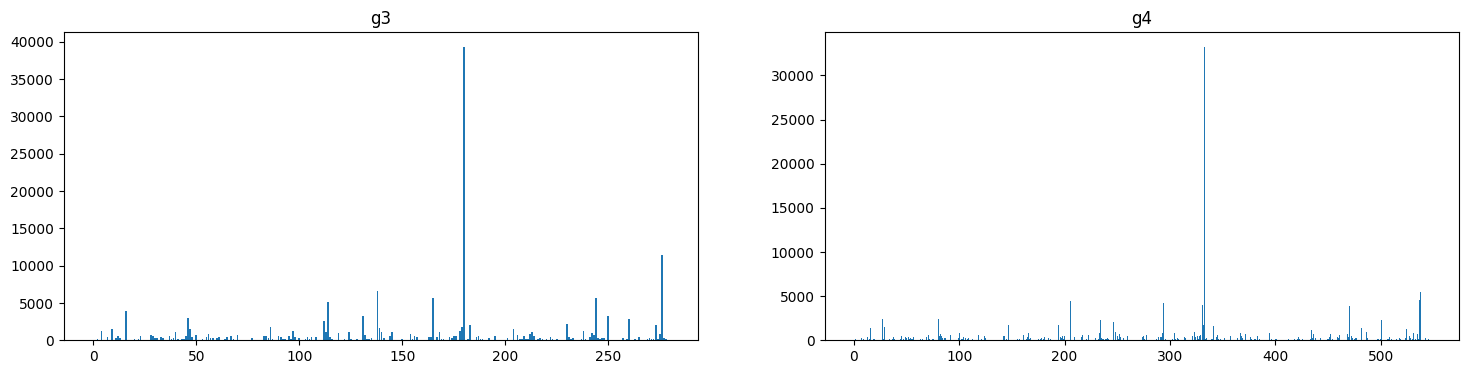

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(18, 4))  # 1 row, 3 columns

for i, geo in enumerate(['g3','g4']):
  geo_distr = df.groupby(geo)['Venue_ID'].size()
# Plot the first bar plot
  axs[i].bar(range(len(geo_distr)), geo_distr)
  axs[i].set_title(geo)


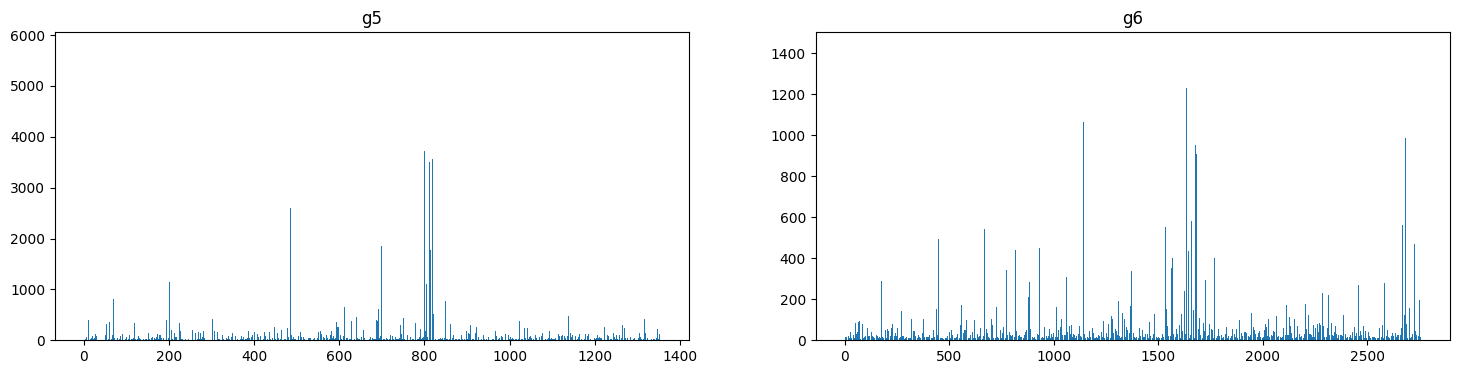

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))  # 1 row, 3 columns

for i, geo in enumerate(['g5','g6']):
  geo_distr = df.groupby(geo)['Venue_ID'].size()
# Plot the first bar plot
  axs[i].bar(range(len(geo_distr)), geo_distr)
  axs[i].set_title(geo)

# Geo-Hierarchical Tree: setup and search methods

In [ ]:
# @title Build the tree using strings for understanding
class GeoNodeHash:
    def __init__(self, ID):
        self.ID = ID
        self.children = []

def build_tree_with_hashes(df, precisions):
    # Initialize the root nodes with unique g3 strings
    root_nodes = [GeoNodeHash(g2) for g2 in df['g2'].unique()]

    # Initialize a dictionary to store nodes by their name
    node_dict = {g2: node for g2, node in zip(df['g2'].unique(), root_nodes)}

    # Iterate through each precision (g4, g5, g6)
    for precision in precisions[1:]:  # Start from g4
        # Extract unique strings for the current precision
        unique_strings = df[f'g{precision}'].unique()

        # Create nodes for unique strings and connect them to their parent nodes
        for string in unique_strings:
            parent_name = string[:-1]  # Get the parent node's name
            parent_node = node_dict[parent_name]  # Get the parent node
            child_node = GeoNodeHash(string)  # Create the child node
            parent_node.children.append(child_node)  # Connect child to parent
            node_dict[string] = child_node  # Add child node to the dictionary

    # Group venues by g6 string and add them as leaf nodes
    grouped_venues = df.groupby('g6')['Venue_ID'].unique().to_dict()
    for g6_value, venues in grouped_venues.items():
        parent_node = node_dict[g6_value]
        for venue in venues:
            child_node = GeoNodeHash(venue)
            parent_node.children.append(child_node)

    return root_nodes

# Construct the tree
GeoTreeRoots = build_tree_with_hashes(df, precisions)

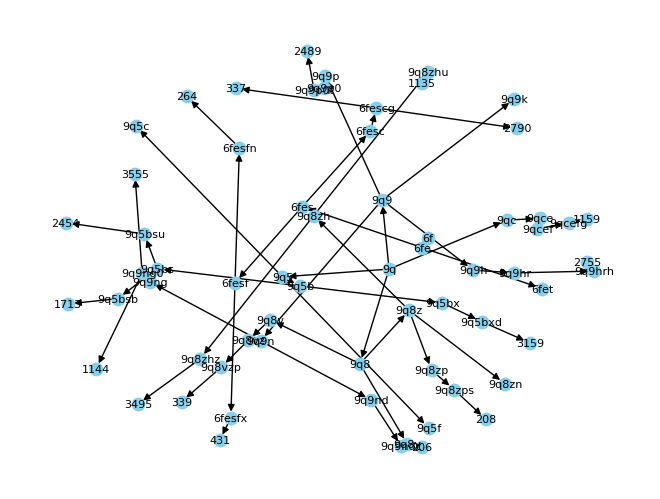

In [ ]:
# @title Plot the tree (pruned for visualization)
import networkx as nx
import matplotlib.pyplot as plt

show_again = True # change to True if you want to re-plot

def add_nodes_edges(G, node):
    if len(node.children) < 5:
      for child in node.children:
          G.add_edge(node.ID, child.ID)
          add_nodes_edges(G, child)

def visualize_tree(root_nodes):
    G = nx.DiGraph()
    for node in root_nodes[:3]:
        add_nodes_edges(G, node)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=80, node_color="skyblue", font_size=8, arrows=True)
    plt.show()

# Visualize the tree
if show_again:
  visualize_tree(GeoTreeRoots)

In [ ]:
for g in ['g2','g3','g4','g5','g6']:
  df[g + "_ID"] = pd.factorize(df[g])[0] + 1

# Drop the original categorical column
df = df.drop(['g2','g3','g4','g5','g6','Latitude','Longitude'], axis=1)
print(df.shape)

(170573, 8)


In [ ]:
df.to_csv("/content/drive/MyDrive/POI_files/GlobalCleanedDataset.csv", index = False)

In [65]:
# @title Build tree using df structure and IDs
from collections import deque
class GeoNode:
    def __init__(self, ID):
        self.ID = ID
        self.children = []
        self.probability = None

    def recursive_assign_prob(self, probability_arrays, current_level = 0):
        '''Visiting each node in a Depth-First style and assign its predicted probability (skipping the NYC root)'''
        probabilities = probability_arrays[current_level]
        for child in self.children:
            if child.ID < len(probabilities):
                child.probability = probabilities[child.ID]
            if child.children:
                child.assign_probabilities(probability_arrays, current_level + 1)

    def assign_probabilities(self, probability_arrays):
        # Initialize a queue for BFS traversal
        queue = deque()
        # Enqueue children of the root (skipping the root itself)
        for child in self.children:
            queue.append((child, 0))  # Tuple: (node, current_level)
        while queue:
            node, current_level = queue.popleft()
            probabilities = probability_arrays[current_level]
            if node.ID < len(probabilities):
                node.probability = probabilities[node.ID]
            else:
              raise ValueError(f'Node {node.ID} out of bound for prob. array of length: {len(probabilities)} at level: {current_level}')
            # Enqueue children for the next level
            for child in node.children:
                queue.append((child, current_level + 1))

    def BFS_joint_prob(self, return_top5 = False):
        if return_top5:
            leaves = []
        else:
            min_leaf = None
            min_log_prob = np.inf
        queue = deque([(self, 0)])  # Using a queue for BFS traversal with joint probability

        while queue:
            node, joint_probability = queue.popleft()
            joint_probability -= node.probability

            if not node.children:  # Check if it's a leaf node
                if return_top5:
                    leaves.append((node.ID, joint_probability))
                else:
                    if joint_probability < min_log_prob:
                        min_leaf = node.ID
                        min_log_prob = joint_probability
            else:
                for child in node.children:
                    queue.append((child, joint_probability))
        if return_top5:
            leaves.sort(key=lambda x: x[1])
            return leaves[:5]
        else:
            return min_leaf, min_log_prob

    def beam_search_joint_prob(self, beam_width=1, return_top5 = False):
        # Initialize beam with root node and log_join probability 1
        beam = [(self, 0)]
        if return_top5:
            leaves = []
        else:
            min_leaf = None
            min_log_prob = np.inf

        while beam:
            # Sort beam by joint probability in descending order
            beam.sort(key=lambda x: x[1])

            # Prune beam to keep only top beam_width nodes
            beam = beam[:beam_width]

            # Initialize next beam
            next_beam = []

            # Explore children of nodes in the current beam
            for node, joint_probability in beam:
                if node.probability is not None:
                    joint_probability -= node.probability # Summing negative-log probability. At the end, who has the lower sum has the highest joint probability.

                # Check if it's a leaf node and update max probability if needed
                if not node.children:
                    if return_top5:
                        leaves.append((node.ID, joint_probability))
                    else:
                        if joint_probability < min_log_prob:
                            min_leaf = node.ID
                            min_log_prob = joint_probability

                # Add children to the next beam
                for child in node.children:
                    next_beam.append((child, joint_probability))

            # Update beam for next iteration
            beam = next_beam
        if return_top5:
            leaves.sort(key=lambda x: x[1])
            return leaves[:5]
        else:
            return min_leaf, min_log_prob

    def DFS_joint_prob(self, current_probability=0):
        # If the node has a probability, update the current probability
        current_probability -= self.probability
        # If it's a leaf node, return the leaf and its joint probability
        if not self.children:
            return self, current_probability

        min_leaf = None
        min_probability = np.inf

        # Recursive DFS traversal for each child
        for child in self.children:
            leaf, probability = child.DFS_joint_prob(current_probability)
            if probability < min_probability:
                min_leaf = leaf
                min_probability = probability

        return min_leaf, min_probability

def build_tree(df):
    # Initialize the branche that holds the "padding" nodes, whose predicitons willhave ID = 0
    padG2, padG3, padG4, padG5, padG6, padVenue = GeoNode(0), GeoNode(0), GeoNode(0), GeoNode(0), GeoNode(0), GeoNode(0)
    padG6.children.append(padVenue)
    padG5.children.append(padG6)
    padG4.children.append(padG5)
    padG3.children.append(padG4)
    padG2.children.append(padG3)
    # Initialize the root nodes with unique g3 IDs
    root_nodes = [GeoNode(g2_id) for g2_id in df['g2_ID'].unique()]

    # Initialize a dictionary to store nodes by their ID
    node_dict = {'g2_node_' + str(g2_id): node for g2_id, node in zip(df['g2_ID'].unique(), root_nodes)}

    # Iterate through each precision (g2, g3, g4, g5, g6, venue)
    precisions = ['g2_ID', 'g3_ID', 'g4_ID', 'g5_ID', 'g6_ID', 'Venue_ID']
    for i in range(len(precisions) - 1):
        parent_precision = precisions[i]
        child_precision = precisions[i + 1]

        # Group by parent ID and get children IDs
        grouped_children = df.groupby(parent_precision)[child_precision].unique()

        # Create child nodes and connect them to their parent nodes
        for parent_id, children_ids in grouped_children.items():
            parent_node = node_dict[parent_precision[:3] +'node_' + str(parent_id)]
            for child_id in children_ids:
                child_node = GeoNode(child_id)
                parent_node.children.append(child_node)
                node_dict[child_precision[:3] + 'node_' + str(child_id)] = child_node  # Add child node to the dictionary

    NYC = GeoNode(None)
    NYC.children = [padG2] + root_nodes # append to the "virtual" single root the root_nodes(g3 cells) proceed by the padding branch
    NYC.probability = 0
    return NYC

# Construct the tree
GeoTree = build_tree(df)

In [ ]:
# test by random assignment
p_list = [np.random.uniform(-10, -1, 112), np.random.uniform(-10, -1, 281), np.random.uniform(-10, -1, 548), np.random.uniform(-10, -1, 1355), np.random.uniform(-10, -1, 2758), np.random.uniform(-10, -1, 4456)]
np.random.seed(42) # I'll give high probability (log) to the padding branch to see if it works
GeoTree.assign_probabilities(p_list)

In [ ]:
%timeit GeoTree.assign_probabilities(p_list)

11.4 ms ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
GeoTree.beam_search_joint_prob(beam_width=100, return_top5 = True) # first prediction should be the padding

[(3550, 8.799887670453941),
 (399, 12.75737329468423),
 (2112, 13.380161723856933),
 (3903, 14.689830976643957),
 (973, 15.07511734490344)]

In [ ]:
GeoTree.BFS_joint_prob(return_top5 = True)

[(3550, 8.799887670453941),
 (399, 12.75737329468423),
 (2112, 13.380161723856933),
 (3903, 14.689830976643957),
 (973, 15.07511734490344)]

In [ ]:
# testing time efficiency of different search methods
%timeit GeoTree.BFS_joint_prob(return_top5 = True) # Computes top-5 ranked set of leaves
%timeit GeoTree.BFS_joint_prob() # Computes just top-1 leaf
%timeit GeoTree.DFS_joint_prob() # Computes top-1 leaf
%timeit GeoTree.beam_search_joint_prob(beam_width=100, return_top5 = True) # computes log_prob and top-5
%timeit GeoTree.beam_search_joint_prob(beam_width=100) # computes log_prob and top-1

11.5 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.36 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.55 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
585 µs ± 9.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
554 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Dataset and batch pre-processing for torch dataloader

In [6]:
df = pd.read_csv("/content/drive/MyDrive/POI_files/GlobalCleanedDataset.csv")

In [7]:
# @title Train-Validation division
def preprocess_dataset(df):
    # Convert UTC_Time column to datetime
    df['UTC_Time'] = pd.to_datetime(df['UTC_Time'])
    # Sort the dataframe by user_id and UTC_Time
    df_sorted = df.sort_values(by=['User_ID', 'UTC_Time'])
    # Group by user_id and aggregate place_id and grid IDs into lists
    sequences = df_sorted.groupby('User_ID').apply(lambda x: {'Venue_ID': x['Venue_ID'].tolist(),
                                                              'g2_ID': x['g2_ID'].tolist(),
                                                              'g3_ID': x['g3_ID'].tolist(),
                                                              'g4_ID': x['g4_ID'].tolist(),
                                                              'g5_ID': x['g5_ID'].tolist(),
                                                              'g6_ID': x['g6_ID'].tolist(),})
    user_ids = sequences.index.tolist()
    # Split sequences into training and validation
    train_sequences = {}
    val_sequences = {}

    for user_id, seq_data in sequences.items():
        venue_sequence = seq_data['Venue_ID']
        g2_sequence = seq_data['g2_ID']
        g3_sequence = seq_data['g3_ID']
        g4_sequence = seq_data['g4_ID']
        g5_sequence = seq_data['g5_ID']
        g6_sequence = seq_data['g6_ID']


        split_index = int(0.8 * len(venue_sequence))  # 80-20 split

        train_sequences[user_id] = {'Venue_ID': venue_sequence[ : split_index],
                                     'g2_ID': g2_sequence[ : split_index],
                                     'g3_ID': g3_sequence[ : split_index],
                                     'g4_ID': g4_sequence[ : split_index],
                                     'g5_ID': g5_sequence[ : split_index],
                                     'g6_ID': g6_sequence[ : split_index],}

        val_sequences[user_id] = {'Venue_ID': venue_sequence[split_index : ],
                                   'g2_ID': g2_sequence[split_index : ],
                                   'g3_ID': g3_sequence[split_index : ],
                                   'g4_ID': g4_sequence[split_index : ],
                                   'g5_ID': g5_sequence[split_index : ],
                                   'g6_ID': g6_sequence[split_index : ]}

    return train_sequences, val_sequences

In [8]:
# @title Custom torch "Dataset"
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sequences_with_geohash):
        self.sequences_with_geohash = sequences_with_geohash

    def __len__(self):
        return len(self.sequences_with_geohash) # = number of users

    def __getitem__(self, idx):
        seq_dict = self.sequences_with_geohash[idx] # select a specific user
        # Construct input sequences for user_ID = idx
        inputs = ( torch.tensor(seq_dict['Venue_ID'][:-1],dtype=torch.int64), torch.tensor(seq_dict['g2_ID'][:-1],dtype=torch.int64),
                   torch.tensor(seq_dict['g3_ID'][:-1],dtype=torch.int64), torch.tensor(seq_dict['g4_ID'][:-1],dtype=torch.int64),
                   torch.tensor(seq_dict['g5_ID'][:-1],dtype=torch.int64), torch.tensor(seq_dict['g6_ID'][:-1],dtype=torch.int64),)

        targets = ( torch.tensor(seq_dict['Venue_ID'][1:],dtype=torch.int64), torch.tensor(seq_dict['g2_ID'][1:],dtype=torch.int64),
                   torch.tensor(seq_dict['g3_ID'][1:],dtype=torch.int64), torch.tensor(seq_dict['g4_ID'][1:],dtype=torch.int64),
                  torch.tensor(seq_dict['g5_ID'][1:],dtype=torch.int64), torch.tensor(seq_dict['g6_ID'][1:],dtype=torch.int64))

        user_id = torch.tensor(idx)

        return inputs, targets, user_id # this will be an element in the batch

In [9]:
# @title Batch padding for variable-length sequences
import torch

def custom_collate(batch):
    # Unzip the batch into separate lists of inputs, targets, and user IDs
    inputs_batch, targets_batch, user_ids_batch = zip(*batch)

    # Get the maximum length of the venue sequences in the batch
    max_venue_length = max(len(inputs[0]) for inputs in inputs_batch)  # Assuming venue sequences are always at index 0

    # Initialize lists to store padded inputs, targets, and user IDs
    padded_inputs_batch = []
    padded_targets_batch = []
    user_ids_tensor = torch.tensor(user_ids_batch)

    # Pad each sequence type in the batch to match the maximum venue length
    for inputs, targets in zip(inputs_batch, targets_batch):
        padded_inputs = []
        padded_targets = []

        padding = max_venue_length - len(inputs[0])

        for i in range(len(inputs)):
            # Pad the sequences to match the maximum venue length
            padded_input = torch.nn.functional.pad(inputs[i], (0, padding))
            padded_target = torch.nn.functional.pad(targets[i], (0, padding))
            padded_inputs.append(padded_input)
            padded_targets.append(padded_target)

        padded_inputs_batch.append(tuple(padded_inputs))
        padded_targets_batch.append(tuple(padded_targets))

    # Convert the lists of padded inputs and targets into tensors
    padded_inputs_tensor = tuple(map(torch.stack, zip(*padded_inputs_batch)))
    padded_targets_tensor = tuple(map(torch.stack, zip(*padded_targets_batch)))

    return (padded_inputs_tensor, padded_targets_tensor, user_ids_tensor)


# HMT-LSTM

In [ ]:
# @title Model
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn.utils.rnn import pad_sequence

# Define LightningModule
class StackedLSTMClassifier(pl.LightningModule):
    def __init__(self, lengths, embedding_dim, hidden_size_lstm, num_layers_lstm, dropout_prob=0.33):
        super(StackedLSTMClassifier, self).__init__()

        self.embeddingUser = nn.Embedding(lengths['num_of_users'], embedding_dim)
        self.embeddingVenue = nn.Embedding(lengths['num_of_venues'], embedding_dim, padding_idx = 0)
        self.embeddingG2 = nn.Embedding(lengths['num_of_G2'], embedding_dim, padding_idx = 0)
        self.embeddingG3 = nn.Embedding(lengths['num_of_G3'], embedding_dim, padding_idx = 0)
        self.embeddingG4 = nn.Embedding(lengths['num_of_G4'], embedding_dim, padding_idx = 0)
        self.embeddingG5 = nn.Embedding(lengths['num_of_G5'], embedding_dim, padding_idx = 0)
        self.embeddingG6 = nn.Embedding(lengths['num_of_G6'], embedding_dim, padding_idx = 0)

        self.lstm = nn.LSTM(embedding_dim, hidden_size_lstm, num_layers=num_layers_lstm, batch_first=True)

        self.fc_user_venue = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_venues'])
        self.fc_G2 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G2'])
        self.fc_G3 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G3'])
        self.fc_G4 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G4'])
        self.fc_G5 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G5'])
        self.fc_G6 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G6'])

        self.dropout = nn.Dropout(dropout_prob)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, v, g2, g3, g4, g5, g6, user_id):
        # Input x: (batch, seqlen)
        venue_embeddings = self.embeddingVenue(v)
        G2_emb = self.embeddingG2(g2)
        G3_emb = self.embeddingG3(g3)
        G4_emb = self.embeddingG4(g4)
        G5_emb = self.embeddingG5(g5)
        G6_emb = self.embeddingG6(g6)
        # Embed = (batch, seqlen, embed)
        # Input user_id: (batch)
        user_embeddings = self.embeddingUser(user_id)
        # Embed user = (batch, embed)
        lstm_out, _ = self.lstm(venue_embeddings)
        # Concatenate user embeddings to LSTM output
        lstm_out_with_user = torch.cat((lstm_out, user_embeddings.unsqueeze(1).repeat(1, lstm_out.size(1), 1)), dim=-1)
        lstm_out_with_G2 = torch.cat((lstm_out, G2_emb), dim = -1)
        lstm_out_with_G3 = torch.cat((lstm_out, G3_emb), dim = -1)
        lstm_out_with_G4 = torch.cat((lstm_out, G4_emb), dim = -1)
        lstm_out_with_G5 = torch.cat((lstm_out, G5_emb), dim = -1)
        lstm_out_with_G6 = torch.cat((lstm_out, G6_emb), dim = -1)

        # Apply linear layer after dropout
        out_user = self.logsoftmax(self.fc_user_venue(self.dropout(lstm_out_with_user)))
        out_g2 = self.logsoftmax(self.fc_G2(self.dropout(lstm_out_with_G2)))
        out_g3 = self.logsoftmax(self.fc_G3(self.dropout(lstm_out_with_G3)))
        out_g4 = self.logsoftmax(self.fc_G4(self.dropout(lstm_out_with_G4)))
        out_g5 = self.logsoftmax(self.fc_G5(self.dropout(lstm_out_with_G5)))
        out_g6 = self.logsoftmax(self.fc_G6(self.dropout(lstm_out_with_G6)))


        return (out_g2, out_g3, out_g4, out_g5, out_g6, out_user)

    def compute_focal_loss(self, outputs, targets, gamma=2):
        loss = nn.NLLLoss(reduction='none')  # No reduction to compute per-sample losses
        log_probs = outputs.transpose(1, 2)  # Transpose outputs for correct shape
        pt = torch.exp(log_probs).gather(1, targets.unsqueeze(1))
        focal_weights = (1 - pt) ** gamma
        loss = loss(log_probs, targets)
        weighted_loss = focal_weights * loss
        return weighted_loss.mean()

    def compute_loss(self, outputs, v, g2, g3, g4, g5, g6):
        loss_fn = nn.NLLLoss(reduction='mean')
        loss_g2 = self.compute_focal_loss(outputs[0], g2)  # Focal Loss for g6
        loss_g3 = self.compute_focal_loss(outputs[1], g3)  # Focal Loss for g3
        loss_g4 = loss_fn(outputs[2].transpose(1, 2), g4)  # Transpose outputs for correct shape
        loss_g5 = loss_fn(outputs[3].transpose(1, 2), g5)  # Transpose outputs for correct shape
        loss_g6 = loss_fn(outputs[4].transpose(1, 2), g6)  # Transpose outputs for correct shape
        loss_POI = loss_fn(outputs[5].transpose(1, 2), v)  # Transpose outputs for correct shape
        loss_multitask = (loss_POI + loss_g2 + loss_g3 + loss_g4 + loss_g5 + loss_g6) / 6 # Multitask loss
        return loss_multitask

    def training_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        # Unpack the batch
        inputs_batch, targets_batch, user_id = batch

        # Unpack the sequences for each type
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming your model takes inputs and user embeddings

        outputs = self(venues, g2s, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars )

        # Log the training loss
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        inputs_batch, targets_batch, user_id = batch
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming "out_user" corresponds to the "venues" predictions
        outputs = self(venues, g2s, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars)

        predicted = torch.argmax(outputs[5], dim = 2)
        # Flatten predictions and targets to compute accuracy
        predicted = predicted.view(-1)  # Shape: (batch_size * sequence_length)
        targets = venue_tars.view(-1)  # Shape: (batch_size * sequence_length)
        accuracy = ((predicted == targets) & (targets != 0)).sum().item() / (targets != 0).sum().item()

        # Log the validation loss and accuracy
        self.log('val_loss', loss, on_step= False, on_epoch=True)
        self.log('accuracy', accuracy, on_step=False, on_epoch=True)

        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)

In [ ]:
# @title Instantiations
lengths = {'num_of_venues': len(df['Venue_ID'].unique()) + 1, # add one for padding token-index 0, recall each venue/g ID starts from 1
           'num_of_G2': len(df['g2_ID'].unique()) + 1,
           'num_of_G3': len(df['g3_ID'].unique()) + 1,
           'num_of_G4': len(df['g4_ID'].unique()) + 1,
           'num_of_G5': len(df['g5_ID'].unique()) + 1,
           'num_of_G6': len(df['g6_ID'].unique()) + 1,
           'num_of_users': len(df['User_ID'].unique()), # No padding for users since they are not used as sequences but as single-value embedding in the concatenation
           }

hidden_size = 128
embed_dim = 128
num_layers = 2  # Number of LSTM layers

# Separate the sequences into training and validation
train_sequences, val_sequences = preprocess_dataset(df)

model = StackedLSTMClassifier(lengths, embed_dim, hidden_size, num_layers)

# Create separate datasets and dataloaders for training and validation
train_dataset = CustomDataset(train_sequences)
val_dataset = CustomDataset(val_sequences)

# Use custom collate function for handling variable-length sequences
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=2)

In [ ]:
# @title Training
from pytorch_lightning.loggers import TensorBoardLogger

# Instantiate TensorBoardLogger
tb_logger = TensorBoardLogger("logs", name="lstm_logs")

# Instantiate the Trainer with TensorBoardLogger
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1, logger=tb_logger)

# Train the model
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type       | Params
-----------------------------------------------
0  | embeddingUser  | Embedding  | 2.1 M 
1  | embeddingVenue | Embedding  | 570 K 
2  | embeddingG2    | Embedding  | 14.3 K
3  | embeddingG3    | Embedding  | 36.0 K
4  | embeddingG4    | Embedding  | 70.1 K
5  | embeddingG5    | Embedding  | 173 K 
6  | embeddingG6    | Embedding  | 353 K 
7  | lstm           | LSTM       | 264 K 
8  | fc_user_venue  | Linear     | 1.1 M 
9  | fc_G2          | Linear     | 28.8 K
10 | fc_G3          | Linear     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
# Set the model to evaluation mode
import numpy as np
model.eval()

correct_task = np.array([0,0,0,0,0,0])
total_task = np.array([0,0,0,0,0,0])

with torch.no_grad():
    for batch in val_dataloader:
        inputs_batch, targets_batch, user_id = batch
        # Unpack the sequences for each type
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        t = [g2_tars, g3_tars, g4_tars, g5_tars, g6_tars, venue_tars]
        # Assuming your model takes inputs and user embeddings
        outputs = model(venues, g2s, g3s, g4s, g5s, g6s, user_id)
        for i in range(6):
          total = 0
          correct = 0
          _, predicted = torch.max(outputs[i], 2)
          # Flatten predictions and targets to compute accuracy
          predicted = predicted.view(-1)  # Shape: (batch_size * sequence_length)
          targets = t[i].view(-1)         # Shape: (batch_size * sequence_length)
          correct += ((predicted == targets) & (targets != 0)).sum().item()
          total = (targets != 0).sum().item()
          correct_task[i] += correct
          total_task[i] += total

print(total_task, correct_task)
accuracy = correct_task / total_task

[23805 23805 23805 23805 23805 23805] [18963 15920 12076  5612  3545  2975]


In [ ]:
print('Accuracy on validation set', (100 * accuracy))

Accuracy on validation set [79.65973535 66.87670657 50.72883848 23.57487923 14.89182945 12.4973745 ]


In [ ]:
GeoTree = build_tree(df)

In [ ]:
# Set the model to evaluation mode
import numpy as np
model.eval()
total = 0
batchnumber = 0
correct = []
with torch.no_grad():
    for batch in val_dataloader:
        batchnumber+=1
        inputs_batch, targets_batch, user_id = batch
        # Unpack the sequences for each type
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        t = [g2_tars, g3_tars, g4_tars, g5_tars, g6_tars, venue_tars]
        # Assuming your model takes inputs and user embeddings
        outputs = model(venues, g2s, g3s, g4s, g5s, g6s, user_id) # (task X batch X lenseq X classes)
        b_g2, b_g3, b_g4, b_g5, b_g6, b_v = outputs

        for batch_ind in range(b_g2.shape[0]):
          for s in range(b_g2.shape[1]): # iterate over the sequence
            GeoTree.assign_probabilities([b_g2[batch_ind][s].tolist(), b_g3[batch_ind][s].tolist(), b_g4[batch_ind][s].tolist(), b_g5[batch_ind][s].tolist(), b_g6[batch_ind][s].tolist(), b_v[batch_ind][s].tolist()])
            predicted_venue, _ = GeoTree.beam_search_joint_prob(beam_width=150) # returns POI-id and cumulative log-prob
            real = venue_tars[batch_ind][s].item()
            if real != 0:
              correct.append(predicted_venue == real)
              total+=1
            else:
              break

        if batchnumber % 100 == 0:
          print("batch #: ", batchnumber)


batch #:  100
batch #:  200
batch #:  300
batch #:  400
batch #:  500
batch #:  600
batch #:  700
batch #:  800
batch #:  900
batch #:  1000


In [ ]:
print(sum(correct))
print(sum(correct)/total * 100)

3107
13.051879857172862


In [ ]:
print('Accuracy on validation set', (100 * accuracy))

Accuracy on validation set [89.26446795 82.52893591 49.36901058 25.71001867 14.47666459]


# Graphs

In [ ]:
import itertools
import torch
import torch_geometric
from torch_geometric.data import Data
import torch_geometric.transforms as T

In [ ]:
# @title Build spatial-graph
g4group = df.groupby('g4_ID')['Venue_ID'].unique()
spatial_edges = torch.tensor([], dtype=torch.long)

for pois in g4group:
  spatial_edges = torch.cat( (spatial_edges, torch.tensor(list(itertools.permutations(pois, 2)), dtype=torch.long)) )

spatial_nodes = torch.cat((torch.tensor([0]), torch.tensor(df['Venue_ID'].unique())))
spatial_graph = Data(x = spatial_nodes, edge_index=spatial_edges.t())
spatial_graph.is_undirected()

In [ ]:
spatial_edges.shape

In [ ]:
torch.save(spatial_graph, '/content/drive/MyDrive/POI_files/spatial_graph.pt')

In [ ]:
# Find the neighbors of node with ID 4
edge_index = spatial_graph.edge_index
node_id = 4
neighbors = edge_index[1, edge_index[0] == node_id].tolist()

print("Neighbors of node 4:", neighbors[:20], "+ ...")

In [ ]:
df.head()

In [ ]:
# @title Function to calculate time slots
def calculate_time_slot(utc_time):
    utc_time = pd.to_datetime(utc_time)
    day = utc_time.dayofweek  # Monday=0, Sunday=6
    hour = utc_time.hour
    slot = (day * 8) + (hour // 3) + 1  # Calculate time slot
    return slot

# Initialize dictionary to store venue visits
venue_visits = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    venue_id = row['Venue_ID']
    utc_time = row['UTC_Time']

    time_slot = calculate_time_slot(utc_time)

    # Add the time slot to the set of time slots for the venue
    if venue_id in venue_visits:
        venue_visits[venue_id].add(time_slot)
    else:
        venue_visits[venue_id] = {time_slot}

#print(venue_visits)

In [ ]:
# @title Build temporal graph
temporal_edges = []
# Iterate over combinations of venue IDs
for ven, other_ven in itertools.combinations(venue_visits.keys(), 2):
    set_one = venue_visits[ven]
    set_two = venue_visits[other_ven]

    # Calculate Jaccard similarity
    jaccard_similarity = len(set_one.intersection(set_two)) / len(set_one.union(set_two))

    # Add edge if similarity is below threshold
    if jaccard_similarity >= 0.9:
        temporal_edges.append([ven, other_ven])

temporal_edges = torch.tensor(temporal_edges, dtype=torch.long)
temp_nodes = torch.cat( (torch.tensor([0]), torch.tensor(list(venue_visits))) )
temporal_graph = Data(x=temp_nodes, edge_index = temporal_edges.t())
temporal_graph = T.ToUndirected()(temporal_graph)
torch.save(temporal_graph, '/content/drive/MyDrive/POI_files/temporal_graph.pt')
print('Done')

In [ ]:
temporal_graph.edge_index.shape

In [10]:
temp_graph = torch.load('/content/drive/MyDrive/POI_files/temporal_graph.pt')
spat_graph = torch.load('/content/drive/MyDrive/POI_files/spatial_graph.pt')

In [ ]:
from torch_geometric.utils import softmax # please read the comment into the model definition about this magnificient function.

sr = torch.tensor([[1,3,1],
                   [0,7,0],
                   [1,1,1],
                   [2,2,5],
                   [1,1,1],
                   [3,3,3]])

i = torch.tensor([0, 0, 2, 3, 2, 3])

al = softmax(sr, i) # dim = 0 by default
al

In [ ]:
# test to retrieve only edges whose participating nodes are in a given sequence,
# so that we make a gat-convolution only on "needed" nodes and not on entire graph structure
mask = torch.zeros(10, dtype=torch.bool)
sequence = torch.tensor([1, 2, 5, 2, 9])
mask[sequence] = 1
print(mask)
ed = torch.tensor([[1, 1, 4, 3, 2, 7, 3, 5],[4, 3, 1, 1, 7, 2, 5, 3]], dtype = torch.long)
print(ed[0])
print(mask[ed[0]])
ed = ed[:, mask[ed[0]]]
ed

In [ ]:
# test for adding self-loops only on relevant nodes
unique_nodes = torch.unique(ed[0])
# Create a self-loop tensor for the unique nodes
self_loops = torch.stack([unique_nodes, unique_nodes])
# Concatenate the self-loops with the original edge index
ed = torch.cat([ed, self_loops], dim=1)
ed

# HTM-GRN

In [17]:
# @title DGAT-LSTM multi-task model
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax # please read the comment about this special softmax in the method "_attention_coefficients"

class DGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(DGATConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.W_p = torch.nn.Linear(in_channels, out_channels)
        self.W_a = torch.nn.Linear(2 * out_channels, out_channels)
        self.leakyrelu = torch.nn.LeakyReLU()

    def forward(self, x, edge_index, input_nodes):

        # Step 1: Create a mask for the input nodes
        mask = torch.zeros(x.size(0), dtype=torch.bool).to('cuda')
        mask[input_nodes] = 1

        # Step 2: Apply the mask to the edge_index: this increases the efficiency and memory saving by a HUGE amount
        edge_index = edge_index[:, mask[edge_index[0]]]

        # Step 3: Add self-loops to the adjacency matrix, only for the "source" nodes in E, i.e the ones that we need to update.
        source_nodes = torch.unique(edge_index[0])
        self_loops = torch.stack([source_nodes, source_nodes])
          # Concatenate the self-loops with the original edge index
        edge_index = torch.cat([edge_index, self_loops], dim=1)

        # Step 4: Linearly transform node feature matrix. It could be optimized since we need to transform only the nodes in input seq. and their neighbors
        x = self.W_p(x)

        # Step 5: Compute attention coefficients.
        alpha = self._attention_coefficients(x, edge_index)

        # Step 6: Perform the message passing.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, alpha=alpha)

    def _attention_coefficients(self, x, edge_index):
        x_i = torch.index_select(x, 0, edge_index[0])
        x_j = torch.index_select(x, 0, edge_index[1])
        alpha = self.leakyrelu( self.W_a(torch.cat([x_i, x_j], dim=-1)) )
        # Apply softmax to the neighbors of each node, it comes from torch_geomtric.utils.
        # It applies a "grouped" softmax: Given a value tensor :attr:`src`, this function first
        # groups the values along the first dimension based on the indices specified in :attr:`index`,
        # and then proceeds to compute the softmax individually for each group. It also support multidimensional
        # tensors to which specify the dim parameter (default = 0), the axis along which performing the element-wise softmax
        alpha = softmax(alpha, edge_index[0]) # It took me, precisely, 9 hours and 18 minutes + 2 coffees and unimaginable frustration to find this function. Please take care of it.

        return alpha # shape [num_edges, embed_dim]

    def message(self, x_j, alpha):
        return alpha * x_j

# Define LightningModule
class HMT_GRN(pl.LightningModule):
    def __init__(self, lengths, embedding_dim, hidden_size, num_layers_lstm, spat_edges, temp_edges, dropout_prob=0.5):
        super(HMT_GRN, self).__init__()
        self.save_hyperparameters()

        # Embeddings
        self.embeddingUser = nn.Embedding(lengths['num_of_users'], embedding_dim)
        self.embeddingVenue = nn.Embedding(lengths['num_of_venues'], embedding_dim, padding_idx = 0)
        self.embeddingG2 = nn.Embedding(lengths['num_of_G2'], embedding_dim, padding_idx = 0)
        self.embeddingG3 = nn.Embedding(lengths['num_of_G3'], embedding_dim, padding_idx = 0)
        self.embeddingG4 = nn.Embedding(lengths['num_of_G4'], embedding_dim, padding_idx = 0)
        self.embeddingG5 = nn.Embedding(lengths['num_of_G5'], embedding_dim, padding_idx = 0)
        self.embeddingG6 = nn.Embedding(lengths['num_of_G6'], embedding_dim, padding_idx = 0)

        # LSTM
        self.lstm = nn.LSTM(embedding_dim + 2*hidden_size, hidden_size, num_layers=num_layers_lstm, batch_first=True)

        # DGAT
        self.temp_edges = temp_edges.to('cuda')
        self.spat_edges = spat_edges.to('cuda')
        self.dgat_temp_layer = DGATConv(embedding_dim, hidden_size)
        self.dgat_spat_layer = DGATConv(embedding_dim, hidden_size)

        # Final projections
        self.fc_user_venue = nn.Linear(hidden_size + embedding_dim, lengths['num_of_venues'])
        self.fc_G2 = nn.Linear(hidden_size + embedding_dim, lengths['num_of_G2'])
        self.fc_G3 = nn.Linear(hidden_size + embedding_dim, lengths['num_of_G3'])
        self.fc_G4 = nn.Linear(hidden_size + embedding_dim, lengths['num_of_G4'])
        self.fc_G5 = nn.Linear(hidden_size + embedding_dim, lengths['num_of_G5'])
        self.fc_G6 = nn.Linear(hidden_size + embedding_dim, lengths['num_of_G6'])
        self.dropout = nn.Dropout(dropout_prob)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, v, g2, g3, g4, g5, g6, user_id):
        # Input x: (batch, seqlen)
        venue_embeddings = self.embeddingVenue(v)

        batch_size, seq_len = v.size()
        # Get entire embedding matrix
        all_venues_embed = self.embeddingVenue.weight  # Shape: (num_of_venues, embed_size)

        # Flatten the batch of sequences into a 1D tensor
        v_flat = v.view(-1)  # Shape: (batch * seqlen,)

        # Apply GAT operation
        temp_gat_outputs = self.dgat_temp_layer(all_venues_embed, self.temp_edges, v_flat) # returns whole node embedding matrix (with only the node in the input sequences updated)
        temp_gat_embeddings = temp_gat_outputs[v_flat] # we retrieve only the new-node embeddings present in the input sequences
        # Reshape back to original sequence shape
        temp_gat_embeddings = temp_gat_embeddings.view(batch_size, seq_len, -1) # batch, seqlen, hidden_size
        # Same procedure for spatial graph
        spat_gat_outputs = self.dgat_spat_layer(all_venues_embed, self.spat_edges, v_flat) # returns whole node embedding matrix (with only the node in the input sequences updated)
        spat_gat_embeddings = spat_gat_outputs[v_flat] # we retrieve only the new-node embeddings present in the input sequences
        spat_gat_embeddings = spat_gat_embeddings.view(batch_size, seq_len, -1) # batch, seqlen, hidden_size

        G2_emb = self.embeddingG2(g2)
        G3_emb = self.embeddingG3(g3)
        G4_emb = self.embeddingG4(g4)
        G5_emb = self.embeddingG5(g5)
        G6_emb = self.embeddingG6(g6)
        # Embed = (batch, seqlen, embed)
        # Input user_id: (batch)
        user_embeddings = self.embeddingUser(user_id)

        # Embed user = (batch, embed)
        lstm_out, _ = self.lstm(torch.cat((venue_embeddings, temp_gat_embeddings, spat_gat_embeddings), dim=-1))

        # Concatenate user embeddings to LSTM output
        lstm_out_with_user = torch.cat((lstm_out, user_embeddings.unsqueeze(1).repeat(1, lstm_out.size(1), 1)), dim=-1)
        lstm_out_with_G2 = torch.cat((lstm_out, G2_emb), dim = -1)
        lstm_out_with_G3 = torch.cat((lstm_out, G3_emb), dim = -1)
        lstm_out_with_G4 = torch.cat((lstm_out, G4_emb), dim = -1)
        lstm_out_with_G5 = torch.cat((lstm_out, G5_emb), dim = -1)
        lstm_out_with_G6 = torch.cat((lstm_out, G6_emb), dim = -1)

        # Apply linear layer after dropout
        out_user = self.logsoftmax(self.fc_user_venue(self.dropout(lstm_out_with_user)))
        out_g2 = self.logsoftmax(self.fc_G2(self.dropout(lstm_out_with_G2)))
        out_g3 = self.logsoftmax(self.fc_G3(self.dropout(lstm_out_with_G3)))
        out_g4 = self.logsoftmax(self.fc_G4(self.dropout(lstm_out_with_G4)))
        out_g5 = self.logsoftmax(self.fc_G5(self.dropout(lstm_out_with_G5)))
        out_g6 = self.logsoftmax(self.fc_G6(self.dropout(lstm_out_with_G6)))

        return (out_g2, out_g3, out_g4, out_g5, out_g6, out_user)

    def compute_focal_loss(self, outputs, targets, gamma=2):
        loss = nn.NLLLoss(reduction='none')  # No reduction to compute per-sample losses
        log_probs = outputs.transpose(1, 2)  # Transpose outputs for correct shape
        pt = torch.exp(log_probs).gather(1, targets.unsqueeze(1))
        focal_weights = (1 - pt) ** gamma
        loss = loss(log_probs, targets)
        weighted_loss = focal_weights * loss
        return weighted_loss.mean()

    def compute_loss(self, outputs, v, g2, g3, g4, g5, g6):
        loss_fn = nn.NLLLoss(reduction='mean')
        loss_g2 = self.compute_focal_loss(outputs[0], g2)  # Focal Loss for g6
        loss_g3 = self.compute_focal_loss(outputs[1], g3)  # Focal Loss for g3
        loss_g4 = loss_fn(outputs[2].transpose(1, 2), g4)  # Transpose outputs for correct shape
        loss_g5 = loss_fn(outputs[3].transpose(1, 2), g5)  # Transpose outputs for correct shape
        loss_g6 = loss_fn(outputs[4].transpose(1, 2), g6)  # Transpose outputs for correct shape
        loss_POI = loss_fn(outputs[5].transpose(1, 2), v)  # Transpose outputs for correct shape
        loss_multitask = (loss_POI + loss_g2 + loss_g3 + loss_g4 + loss_g5 + loss_g6) / 6
        return loss_multitask

    def training_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        # Unpack the batch
        inputs_batch, targets_batch, user_id = batch

        # Unpack the sequences for each type
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming your model takes inputs and user embeddings

        outputs = self(venues, g2s, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars )

        # Log the training loss
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        inputs_batch, targets_batch, user_id = batch
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming "out_user" corresponds to the "venues" predictions
        outputs = self(venues, g2s, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars)

        predicted = torch.argmax(outputs[5], dim = 2)
        # Flatten predictions and targets to compute accuracy
        predicted = predicted.view(-1)  # Shape: (batch_size * sequence_length)
        targets = venue_tars.view(-1)  # Shape: (batch_size * sequence_length)
        accuracy = ((predicted == targets) & (targets != 0)).sum().item() / (targets != 0).sum().item()

        # Log the validation loss and accuracy
        self.log('val_loss', loss)
        self.log('accuracy', accuracy)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [18]:
# @title Instantiations
lengths = {'num_of_venues': len(df['Venue_ID'].unique()) + 1, # add one for padding token-index 0, recall each venue/g ID starts from 1
           'num_of_G2': len(df['g2_ID'].unique()) + 1,
           'num_of_G3': len(df['g3_ID'].unique()) + 1,
           'num_of_G4': len(df['g4_ID'].unique()) + 1,
           'num_of_G5': len(df['g5_ID'].unique()) + 1,
           'num_of_G6': len(df['g6_ID'].unique()) + 1,
           'num_of_users': len(df['User_ID'].unique()), # No padding for users since they are not used as sequences but as single-value embedding in the concatenation
           }

# Separate the sequences into training and validation
train_sequences, val_sequences = preprocess_dataset(df)

temporal_edges = temp_graph.edge_index
spatial_edges = spat_graph.edge_index

# Create separate datasets and dataloaders for training and validation
train_dataset = CustomDataset(train_sequences)
val_dataset = CustomDataset(val_sequences)

# Use custom collate function for handling variable-length sequences
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=2)

In [19]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [20]:
!rm -rf logs

In [21]:
!rm -rf lightning_logs

In [ ]:
num_layers = 1

choices =  [128, 256, 512, 1024]

data_dict = {
    'hyperparam': choices,
    'accuracy': [None, None, None, None],  # Replace with actual accuracy values
    'val_loss': [None, None, None, None]  # Replace with actual validation loss values
}
# Create the DataFrame
val_df = pd.DataFrame(data_dict)

for embed_hid_dim in choices:

    checkpoint_callback = ModelCheckpoint(
      monitor='accuracy',  # Choose the validation metric to monitor
      mode='max',          # 'min' for loss, 'max' for accuracy
      save_top_k=1,        # Save only the best checkpoint
      filename=f'best_model_dim={embed_hid_dim}'
    )

    tb_logger = TensorBoardLogger("/content/drive/MyDrive/POI_files/logs", name="tuning_GRN_dim_logs")
    # Initialize the model
    model = HMT_GRN(lengths, embed_hid_dim, embed_hid_dim, num_layers, temporal_edges, spatial_edges)

    # Train the model
    trainer = pl.Trainer(max_epochs=25, accelerator="gpu", devices=1, logger=tb_logger, callbacks=[checkpoint_callback])
    trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

for ver, param in enumerate(choices):
    print(f"Testing best model with param = {param}")
    trainer = pl.Trainer(accelerator="gpu", devices=1)
    model = HMT_GRN.load_from_checkpoint(f'/content/drive/MyDrive/POI_files/logs/tuning_GRN_dim_logs/version_{ver}/checkpoints/best_model_dim={param}.ckpt', lengths = lengths, num_layers_lstm = num_layers, spat_edges = spatial_edges, temp_edges = temporal_edges)
    result = trainer.validate(model = model, dataloaders=val_dataloader)
    val_df.loc[val_df['hyperparam'] == param, 'accuracy'] = result[0]['accuracy']
    val_df.loc[val_df['hyperparam'] == param, 'val_loss'] = result[0]['val_loss']

val_df.to_csv('/content/drive/MyDrive/POI_files/HTMGRN_dim_test.csv', index=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type       | Params
------------------------------------------------
0  | embeddingUser   | Embedding  | 2.1 M 
1  | embeddingVenue  | Embedding  | 570 K 
2  | embeddingG2     | Embedding  | 14.3 K
3  | embeddingG3     | Embedding  | 36.0 K
4  | embeddingG4     | Embedding  | 70.1 K
5  | embeddingG5     | Embedding  | 173 K 
6  | embeddingG6     | Embedding  | 353 K 
7  | lstm            | LSTM       | 263 K 
8  | dgat_temp_layer | DGATConv   | 49.4 K
9  | dgat_spat_layer | DGATConv   | 49.4 K
10 | fc_user_venue   | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type       | Params
------------------------------------------------
0  | embeddingUser   | Embedding  | 4.3 M 
1  | embeddingVenue  | Embedding  | 1.1 M 
2  | embeddingG2     | Embedding  | 28.7 K
3  | embeddingG3     | Embedding  | 71.9 K
4  | embeddingG4     | Embedding  | 140 K 
5  | embeddingG5     | Embedding  | 346 K 
6  | embeddingG6     | Embedding  | 706 K 
7  | lstm            | LSTM       | 1.1 M 
8  | dgat_temp_lay

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type       | Params
------------------------------------------------
0  | embeddingUser   | Embedding  | 8.5 M 
1  | embeddingVenue  | Embedding  | 2.3 M 
2  | embeddingG2     | Embedding  | 57.3 K
3  | embeddingG3     | Embedding  | 143 K 
4  | embeddingG4     | Embedding  | 280 K 
5  | embeddingG5     | Embedding  | 693 K 
6  | embeddingG6     | Embedding  | 1.4 M 
7  | lstm            | LSTM       | 4.2 M 
8  | dgat_temp_lay

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [46]:
val_df

,hyperparam,accuracy,val_loss
0,64,0.000885,4.589456
1,128,0.000635,4.188125
2,256,0.000856,4.101242
3,512,0.002128,3.873292
4,1024,0.010851,3.524612


In [69]:
GeoTree = build_tree(df)

In [75]:
# Set the model to evaluation mode
import numpy as np
model = HMT_GRN.load_from_checkpoint('/content/logs/tuning_GRN_dim_logs/version_0/checkpoints/best_model-epoch=11-val_loss=1.3814.ckpt', lengths = lengths, num_layers_lstm = num_layers, spat_edges = spatial_edges, temp_edges = temporal_edges)
print(model)
model.eval()
correct = []

with torch.no_grad():
    for batch in val_dataloader:
        batchnumber+=1
        inputs_batch, targets_batch, user_id = batch
        # Unpack the sequences for each type
        venues, g2s, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g2_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch # each of these outputs has shape (batch, sequence_length), each entry is an integer representing the class
        t = [g2_tars, g3_tars, g4_tars, g5_tars, g6_tars, venue_tars]
        # Assuming your model takes inputs and user embeddings
        outputs = model(venues.to('cuda'), g2s.to('cuda'), g3s.to('cuda'), g4s.to('cuda'), g5s.to('cuda'), g6s.to('cuda'), user_id.to('cuda'))
        b_g2, b_g3, b_g4, b_g5, b_g6, b_v = outputs # these have shape (batch, sequence_length, classes)

        for batch_ind in range(b_g2.shape[0]): # iterate over batches
          for s in range(b_g2.shape[1]): # iterate over the sequence
            GeoTree.assign_probabilities([b_g2[batch_ind][s].tolist(), b_g3[batch_ind][s].tolist(), b_g4[batch_ind][s].tolist(), b_g5[batch_ind][s].tolist(), b_g6[batch_ind][s].tolist(), b_v[batch_ind][s].tolist()])
            predicted_venue, _ = GeoTree.beam_search_joint_prob(beam_width=150) # returns POI-id and cumulative log-prob
            real = venue_tars[batch_ind][s].item()
            if real != 0:
              correct.append(predicted_venue == real)
            else:
              break

    print('The End.')




HMT_GRN(
  (embeddingUser): Embedding(16636, 512)
  (embeddingVenue): Embedding(4456, 512, padding_idx=0)
  (embeddingG2): Embedding(112, 512, padding_idx=0)
  (embeddingG3): Embedding(281, 512, padding_idx=0)
  (embeddingG4): Embedding(548, 512, padding_idx=0)
  (embeddingG5): Embedding(1355, 512, padding_idx=0)
  (embeddingG6): Embedding(2758, 512, padding_idx=0)
  (lstm): LSTM(1536, 512, batch_first=True)
  (dgat_temp_layer): DGATConv()
  (dgat_spat_layer): DGATConv()
  (fc_user_venue): Linear(in_features=1024, out_features=4456, bias=True)
  (fc_G2): Linear(in_features=1024, out_features=112, bias=True)
  (fc_G3): Linear(in_features=1024, out_features=281, bias=True)
  (fc_G4): Linear(in_features=1024, out_features=548, bias=True)
  (fc_G5): Linear(in_features=1024, out_features=1355, bias=True)
  (fc_G6): Linear(in_features=1024, out_features=2758, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (logsoftmax): LogSoftmax(dim=-1)
)
batch #:  100
batch #:  200
batch #:  300
b

In [77]:
print(sum(correct))
print(sum(correct)/len(correct)* 100) #13.2283 for 256, 13.1359 for 512, 13.2997 for 1024

3127
13.135895820205839
